## Tratamento dos dados

#### Importação das bibliotecas

In [3]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral
from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [4]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['italian_serie_a.csv',
 'english_premier_league.csv',
 'german_bundesliga_1.csv',
 'english_championship.csv',
 'portugese_liga_nos.csv',
 'russian_premier_liga.csv',
 'spanish_primera_division.csv',
 'french_ligue_1.csv',
 'dutch_eredivisie.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [5]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    dir = "./data/transfers_master/data/"+ year + "/dutch_eredivisie.csv"
    data = pd.read_csv(dir)

    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[1:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            
            # Concatenação dos dados
            data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [6]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
data

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC,?,in,Summer,NaN,Eredivisie,1992,1992/1993
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,Summer,NaN,Eredivisie,1992,1992/1993
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,Summer,NaN,Eredivisie,1992,1992/1993
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,Summer,0.0,Eredivisie,1992,1992/1993
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,Summer,0.0,Eredivisie,1992,1992/1993
...,...,...,...,...,...,...,...,...,...,...,...,...
254,FC Utrecht,Willem van der Ark,29.0,Centre-Forward,ADO Den Haag,?,out,Winter,NaN,Eredivisie,1992,1992/1993
255,Roda JC Kerkrade,Arkadiusz Kaliszan,20.0,Defensive Midfield,Warta Poznan,?,in,Winter,NaN,Eredivisie,1992,1992/1993
256,Roda JC Kerkrade,Sergiy Pogodin,24.0,Attacking Midfield,Shakhtar D.,?,in,Winter,NaN,Eredivisie,1992,1992/1993
257,Roda JC Kerkrade,Eugène Hanssen,33.0,Defender,Verdy Kawasaki,?,out,Winter,NaN,Eredivisie,1992,1992/1993


In [7]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [8]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

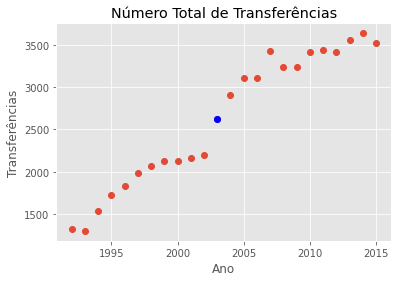

In [39]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era");

## Pré-Galácticos e Pós-Galacticos

O gráfico acima mostra a evolução no número de transferências de jogadores ao longo dos anos, dessa forma pode-se perceber que 2003 foi o ano em que houve a maior evolução no número de movimentações no mercado do futebol europeu da história. Portanto, deixou-se essa data como destaque em azul no gráfico, marcando o fim da era dos galácticos e o começo da era pós galácticos.

Assim, como o segundo gráfico mostra os anos em rosa que indicam a era pré-galácticos e os em azul a era pós-galácticos. 

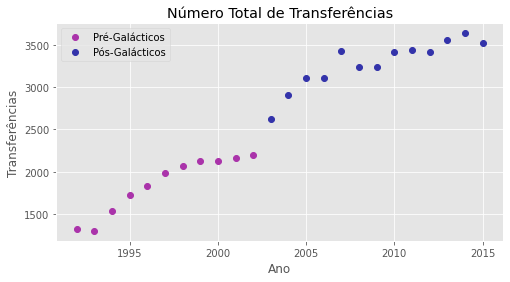

In [10]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [11]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [12]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
data_in

,index,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC Kerkrade,?,in,Summer,NaN,Eredivisie,1992,1992/1993
1,1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,Summer,NaN,Eredivisie,1992,1992/1993
2,2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,Summer,NaN,Eredivisie,1992,1992/1993
3,3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,Summer,0.0,Eredivisie,1992,1992/1993
4,8,Dordrecht'90,Michel Langerak,23.0,Attacking Midfield,VVV-Venlo,?,in,Summer,NaN,Eredivisie,1992,1992/1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63026,575,Roda JC Kerkrade,Georgi Zhukov,21.0,Central Midfield,Standard Res.,Loan,in,Winter,0.0,Eredivisie,2015,2015/2016
63027,576,Roda JC Kerkrade,Martin Milec,24.0,Right-Back,Standard Liège,Loan,in,Winter,0.0,Eredivisie,2015,2015/2016
63028,577,Roda JC Kerkrade,Mike van Duinen,24.0,Centre-Forward,F. Düsseldorf,Loan,in,Winter,0.0,Eredivisie,2015,2015/2016
63029,578,Roda JC Kerkrade,Tim Blättler,21.0,Centre-Forward,Roda JC U21,-,in,Winter,0.0,Eredivisie,2015,2015/2016


In [13]:
data_in["year"].value_counts()

2014    3637
2013    3558
2015    3520
2011    3444
2007    3429
2010    3416
2012    3414
2008    3238
2009    3236
2005    3113
2006    3107
2004    2903
2003    2618
2002    2202
2001    2165
1999    2132
2000    2129
1998    2069
1997    1983
1996    1836
1995    1723
1994    1540
1992    1319
1993    1300
Name: year, dtype: int64

In [14]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [15]:
g2 = Graph(directed=True) # dirigido
g2.vp['name'] = g2.new_vp('object')
g2.vp['league'] = g2.new_vp('object')

In [16]:
times = []
for index, rows in data_pos_gal.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        g2.add_vertex()
        v_time = g2.vertex(times.index(time1))
        g2.vp['name'][v_time] = time1
        g2.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        g2.add_vertex()
        v_time = g2.vertex(times.index(time2))
        g2.vp['name'][v_time] = time2
        g2.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if g2.edge(index1, index2) == None:
        g2.add_edge(index1, index2)

In [17]:
stats.remove_self_loops(g2)
m = draw_gt.sfdp_layout(g2)
move_gt(g2, m)
save_gt(g2, 'exemplo3.net.gz')

In [18]:
data_in["league_name"].value_counts()

Championship        12342
Eredivisie          11216
Premier League       9652
Liga Nos             7382
Ligue 1              6365
Primera Division     5988
1 Bundesliga         5163
Premier Liga         4923
Name: league_name, dtype: int64

In [19]:
g2 = load_gt('exemplo3.net.gz')

g2.vp['color'] = g2.new_vp('object')

for v in g2.vertices():
    if g2.vp['league'][v] == "Premier League":
        g2.vp['color'][v] = 0x0000ff
        
    if g2.vp['league'][v] == "Eredivisie":
        g2.vp['color'][v] = 0x00ff00
        
    if g2.vp['league'][v] == "Championship":
        g2.vp['color'][v] = 0x0000f0
        
    if g2.vp['league'][v] == "Serie A":
        g2.vp['color'][v] = 0xff00ff
        
    if g2.vp['league'][v] == "Liga Nos":
        g2.vp['color'][v] = 0xff0000
        
    if g2.vp['league'][v] == "Ligue 1":
        g2.vp['color'][v] = 0xffff00
        
    if g2.vp['league'][v] == "1 Bundesliga":
        g2.vp['color'][v] = 0x1100ff
        
    if g2.vp['league'][v] == "Premier Liga":
        g2.vp['color'][v] = 0x00ffff

m = draw_gt.sfdp_layout(g2)
move_gt(g2, m)
save_gt(g2, 'exemplo4.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [20]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [21]:
centro_periferia(g2, "core")

In [22]:
df = pd.DataFrame({k: list(v) for k, v in g2.vp.items()})
df.head()

,id,name,league,_x,_y,color,core
0,0,Ajax Amsterdam,Eredivisie,1.262687,5.770208,65280.0,1.0
1,1,Newell's,Eredivisie,1.255386,5.845910,65280.0,0.0
2,2,SC Heerenveen,Eredivisie,1.250064,5.732788,65280.0,0.0
3,3,Boca Juniors,Eredivisie,1.299121,5.821463,65280.0,0.0
4,4,Figueirense FC,Eredivisie,1.359227,5.809111,65280.0,0.0


In [23]:
df["league"].value_counts()

Liga Nos            552
Championship        368
Premier Liga        360
Eredivisie          324
Premier League      312
1 Bundesliga        256
Ligue 1             235
Primera Division    186
Name: league, dtype: int64

In [24]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5)
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5)
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5)
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5)
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5)
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5)
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5)
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5)
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

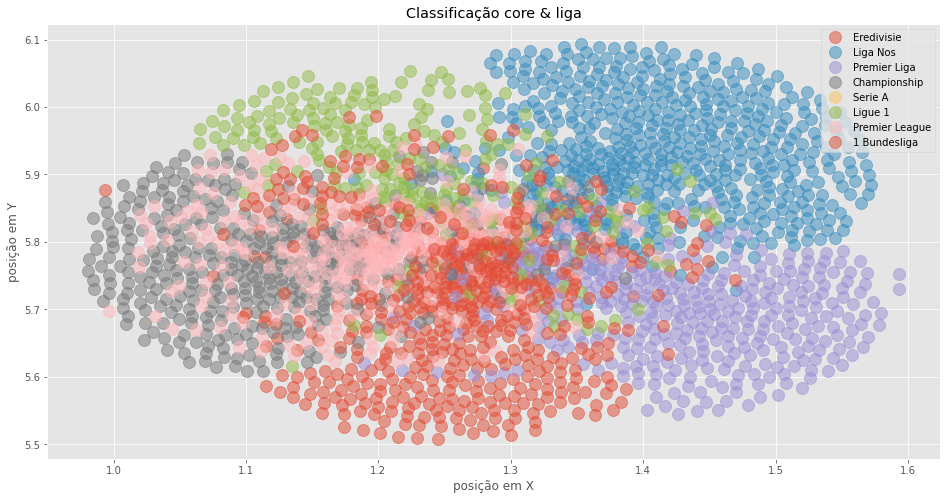

In [25]:
plot_cp(df)

## Conclusão sobre o grafo das tranferências entre clubes europeus

Observando o grafo plotado, é possível observar panelinhas entre as ligas do futebol europeu, fica bem claro a concentração entre os times de mesma liga quando se olha para as cores e os devidos posicionamentos dos vértices ao longo da rede, assim fica mais evidente a possível existência de times que interligam tranferências entre as ligas, os quais corroboram para a hipótese do grupo.

**Hipótese: Times com boa relação com times de diferentes ligas (relacionamento interliga) atingem melhor desempenho na champions league**


In [29]:
def loading_champions_data(DATA_DIR, year, end):
    list_df = []
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    list_df.append(data)
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        
        #data = pd.concat([data, pd.read_csv(dir)])
        data = pd.read_csv(dir)
        list_df.append(data)
    return(list_df)

In [38]:
DATA_DIR = './data/champions_league'
YEAR = 1992

list_df = loading_champions_data(DATA_DIR, YEAR, 2015)
list_df[1]

,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Skonto › LVA (1),0-1,0-0,Olimpija Ljubljana › SVN (1),NaN,NaN,NaN,NaN
1,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Cwmbran Town › WAL (1),3-2,0-0,Cork City › IRL (1),NaN,NaN,NaN,NaN
2,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Avenir Beggen › LUX (1),0-2,0-0,Rosenborg BK › NOR (1),NaN,NaN,NaN,NaN
3,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),B68 Toftir › FRO (1),0-5,0-0,Dinamo Zagreb › CRO (1),NaN,NaN,NaN,NaN
4,NaN,Prelim. Round | Leg 1,NaN,(Wed) 18 Aug 1993 (W33),Zimbru Chisinau › MDA (1),1-1,0-0,Beitar Jerusalem › ISR (1),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
90,Group,Matchday ?,B,(Wed) 13 Apr 1994 (W15),FC Porto › POR (10),0-0,0-0,AC Milan › ITA (10),NaN,NaN,NaN,NaN
91,Group,Matchday ?,B,(Wed) 13 Apr 1994 (W15),RSC Anderlecht › BEL (10),1-2,1-1,Werder Bremen › GER (10),NaN,NaN,NaN,NaN
92,NaN,Semifinals,NaN,(Wed) 27 Apr 1994 (W17),FC Barcelona › ESP (11),3-0,2-0,FC Porto › POR (11),NaN,NaN,NaN,NaN
93,NaN,Semifinals,NaN,(Wed) 27 Apr 1994 (W17),AC Milan › ITA (11),3-0,1-0,AS Monaco › FRA (11),NaN,NaN,NaN,NaN


In [35]:
# dict_teams = {}
# for df in list_df:
    

,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 30 Jun 2015 (W26),Crusaders › NIR (1),0-0,0-0,Levadia › EST (1),NaN,NaN,NaN,NaN
1,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 30 Jun 2015 (W26),Lincoln Red Imps › GIB (1),0-0,0-0,FC Santa Coloma › AND (1),NaN,NaN,NaN,NaN
2,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 30 Jun 2015 (W26),Pyunik › ARM (1),2-1,0-0,S.S. Folgore Falciano Calcio › SMR (1),NaN,NaN,NaN,NaN
3,Qualifying,Qual. Round 1 | Leg 1,NaN,(Wed) 1 Jul 2015 (W26),B36 Torshavn › FRO (1),1-2,0-0,The New Saints › WAL (1),NaN,NaN,NaN,NaN
4,Qualifying,Qual. Round 1 | Leg 2,NaN,(Tue) 7 Jul 2015 (W27),Levadia › EST (2),1-1,0-0,Crusaders › NIR (2),(a) 1-1 (agg.),NaN,NaN,Away Goals (2)
...,...,...,...,...,...,...,...,...,...,...,...,...
212,Knockout,Semifinals | Leg 1,NaN,(Tue) 26 Apr 2016 (W17),Manchester City FC › ENG (11),0-0,0-0,Real Madrid CF › ESP (11),NaN,NaN,NaN,NaN
213,Knockout,Semifinals | Leg 1,NaN,(Wed) 27 Apr 2016 (W17),Atletico Madrid › ESP (11),1-0,1-0,Bayern München › GER (11),NaN,NaN,NaN,NaN
214,Knockout,Semifinals | Leg 2,NaN,(Tue) 3 May 2016 (W18),Bayern München › GER (12),2-1,1-0,Atletico Madrid › ESP (12),(a) 2-2 (agg.),NaN,NaN,Away Goals (2)
215,Knockout,Semifinals | Leg 2,NaN,(Wed) 4 May 2016 (W18),Real Madrid CF › ESP (12),1-0,1-0,Manchester City FC › ENG (12),1-0 (agg.),NaN,NaN,NaN
